In [10]:
import geonomics as gnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# Make continuous colour map
cmapCont = mpl.colors.LinearSegmentedColormap.from_list('heat', ['#000000', '#bd0026', '#bd0026', '#fd8d3c', '#fecc5c'])

import scipy.fftpack
from nlmpy import nlmpy

from pykrige.ok import OrdinaryKriging

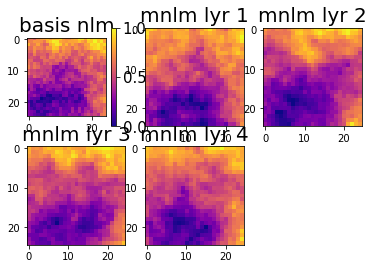

In [11]:
# DETH: 03-01-21: GRF functions taken from Bruno Sciolla's Github repo:
# https://github.com/bsciolla/gaussian-random-fields.git
# Copyright 2017 Bruno Sciolla. All Rights Reserved.
# ==============================================================================
# Generator for 2D scale-invariant Gaussian Random Fields
# ==============================================================================

def fftind(size):
    """ Returns a numpy array of shifted Fourier coordinates k_x k_y.

        Input args:
            size (integer): The size of the coordinate array to create
        Returns:
            k_ind, numpy array of shape (2, size, size) with:
                k_ind[0,:,:]:  k_x components
                k_ind[1,:,:]:  k_y components

        Example:

            print(fftind(5))

            [[[ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]]

            [[ 0  0  0  0  0]
            [ 1  1  1  1  1]
            [-3 -3 -3 -3 -3]
            [-2 -2 -2 -2 -2]
            [-1 -1 -1 -1 -1]]]

        """
    k_ind = np.mgrid[:size, :size] - int( (size + 1)/2 )
    k_ind = scipy.fftpack.fftshift(k_ind)
    return( k_ind )



def draw_gaussian_random_field(alpha = 3.0,
                          size = 128,
                          flag_normalize = True):
    """ Returns a numpy array of shifted Fourier coordinates k_x k_y.

        Input args:
            alpha (double, default = 3.0):
                The power of the power-law momentum distribution
            size (integer, default = 128):
                The size of the square output Gaussian Random Fields
            flag_normalize (boolean, default = True):
                Normalizes the Gaussian Field:
                    - to have an average of 0.0
                    - to have a standard deviation of 1.0

        Returns:
            gfield (numpy array of shape (size, size)):
                The random gaussian random field

        Example:
        import matplotlib
        import matplotlib.pyplot as plt
        example = gaussian_random_field()
        plt.imshow(example)
        """

        # Defines momentum indices
    k_idx = fftind(size)

        # Defines the amplitude as a power law 1/|k|^(alpha/2)
    amplitude = np.power( k_idx[0]**2 + k_idx[1]**2 + 1e-10, -alpha/4.0 )
    amplitude[0,0] = 0

        # Draws a complex gaussian random noise with normal
        # (circular) distribution
    noise = np.random.normal(size = (size, size)) \
        + 1j * np.random.normal(size = (size, size))

        # To real space
    gfield = np.fft.ifft2(noise * amplitude).real

        # Sets the standard deviation to one
    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = gfield/np.std(gfield)

    return gfield

# ==============================================================================


# DETH: 03-01-21: From here below is my code

def krig_surf_from_nlm(nlm, n_pts=100, variogram_model='spherical'):
    # draw random points
    xs = np.random.uniform(0, nlm.shape[1], n_pts)
    ys = np.random.uniform(0, nlm.shape[0], n_pts)
    # sample the baseline nlm at those points
    zs = nlm[np.int8(ys), np.int8(xs)]
    # krig a surface from the sampled points
    OK = OrdinaryKriging(xs, ys, zs, variogram_model='spherical')
    gridx = np.arange(0.5, nlm.shape[1] + 0.5, 1)
    gridy = np.arange(0.5, nlm.shape[0] + 0.5, 1)
    kriged, ss = OK.execute('grid', gridx, gridy)
    return kriged, ss


def draw_n_corr_lyrs(nlm, ss, n_lyrs, grf_alpha=3):
    # create an output arrays with 'n_lyrs' layers,
    # one per dim in the multivariate NLM
    out = np.ones([n_lyrs] + list(nlm.shape)) * np.nan
    # for each layer
    for i in range(n_lyrs):
        # draw a Gaussian random field of the same shape as the NLM
        grf = draw_gaussian_random_field(grf_alpha, nlm.shape[0])
        # multiply the square root of the kriged ss layer
        # by the grf, then add that to the NLM
        out_lyr =  nlm + (grf * np.sqrt(ss))
        # store this as the ith output layer
        out[i, :, :] = out_lyr
    return out


def draw_mv_mpd(n_lyrs, size, grf_alpha=2.5, h=0.5,
                n_krig_pts=100, variogram_model='spherical'):
    """
    Draw a multivariate NLM.

    Arguments
    =========

    n_lyrs: int:
        number of layers in the MNLM

    size: int:
        number of cells per side of the square landscape

    grf_alpha: float: default 2.5:
        alpha value provided to the Gaussian Random Field generator
         The power of the power-law momentum distribution provided to the Gaussian Random Field generator
        TODO: READ ABOUT THIS!

    h: float: default=0.5:
        h parameter provided to the mid-point displacement NLM function
        TODO: READ ABOUT THIS!

    n_krig_pts: int: default=100:
        number of random points to draw and then extract the NLM at in order to
        generate the kriging model

    variogram_model: str: default="spherical":
        type of variogram model for the Ordinary Kriging model to use

    Returns
    =======

    basis_nlm: 2d np.array:
        The NLM used as the basis for the MNLM

    mnlm: 3d np.array:
        The MNLM

    """
    # draw a mid-point displacement NLM
    basis_nlm = nlmpy.mpd(size, size, h)
    # extract some number of random points from the NLM,
    # then produce a kriged surface from them
    krig, ss = krig_surf_from_nlm(basis_nlm, n_pts=n_krig_pts,
                                  variogram_model=variogram_model)
    # used that kriged surface to produce an MNLM
    mnlm = draw_n_corr_lyrs(krig, ss, n_lyrs, grf_alpha=grf_alpha)
    return basis_nlm, mnlm


def plot_mnlm(basis_nlm, mlnm, cmap='plasma'):
    fig = plt.figure()
    # figure out the right number of rows and cols for the paneled plot
    n_rows = int(np.sqrt(len(mlnm)+1))
    n_cols = len(mlnm)//n_rows + ((len(mlnm)+1)%n_rows > 0)
    # plot the basis NLM
    basis_nlm_ax = fig.add_subplot(n_rows, n_cols, 1)
    im = basis_nlm_ax.imshow(basis_nlm, cmap=cmap)
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=15)
    basis_nlm_ax.set_title('basis nlm', fontsize=20)
    # plot each of the MNLM layers
    for i, lyr in enumerate(mlnm):
        ax = fig.add_subplot(n_rows, n_cols, 2+i)
        ax.imshow(lyr, cmap=cmap)
        ax.set_title('mnlm lyr %i' % (i+1), fontsize=20)
    plt.show()


def main():
    basis_nlm, mnlm = draw_mv_mpd(4, 25)
    plot_mnlm(basis_nlm, mnlm)

if __name__ == '__main__':
    main()

In [ ]:

np.random.seed(42)
basis_nlm1, mnlm1 = draw_mv_mpd(4, 40, grf_alpha=2.5, h=0.6, n_krig_pts=10, variogram_model='spherical')
plot_mnlm(basis_nlm1, mnlm1)

mnlm1[1] = np.interp(mnlm1[1], (mnlm1[1].min(), mnlm1[1].max()), (0, 1))
mnlm1[2] = np.interp(mnlm1[2], (mnlm1[2].min(), mnlm1[2].max()), (0, 1))

In [37]:
np.random.seed(1)
size = 40
H = 0.1

n_krig_pts = 10
variogram_model='spherical'
grf_alpha=2.5
n_lyrs = 2

# draw a mid-point displacement NLM
basis_nlm = nlmpy.mpd(size, size, H)
# extract some number of random points from the NLM,
# then produce a kriged surface from them
krig, ss = krig_surf_from_nlm(basis_nlm, n_pts=n_krig_pts,
                                  variogram_model=variogram_model)
# used that kriged surface to produce an MNLM
mnlm = draw_n_corr_lyrs(krig, ss, n_lyrs, grf_alpha=grf_alpha)



0.6
0.9
H=0.5 & r=0.3 finished in 77 its


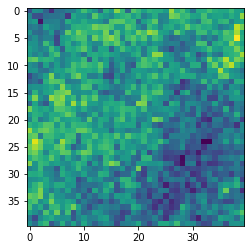

0.3
0.8
H=0.5 & r=0.6 finished in 5 its


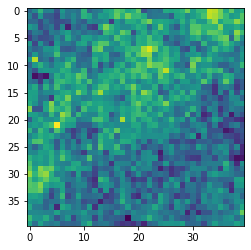

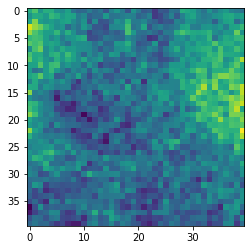

0.6
H=0.1 & r=0.3 finished in 8 its


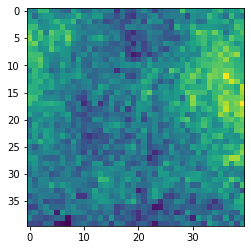

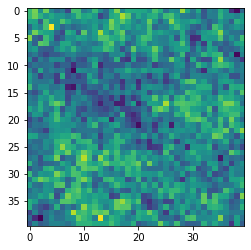

0.4
0.5
0.7
H=0.1 & r=0.6 finished in 14 its


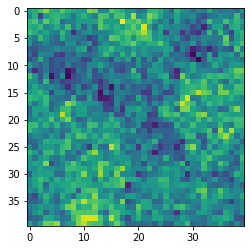

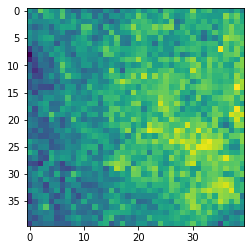

Seed 1 complete
0.8
0.9
H=0.5 & r=0.3 finished in 60 its


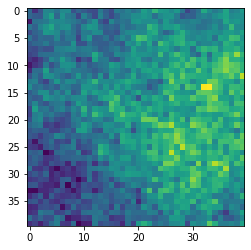

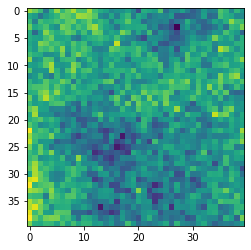

0.7
0.8
0.9
H=0.5 & r=0.6 finished in 16 its


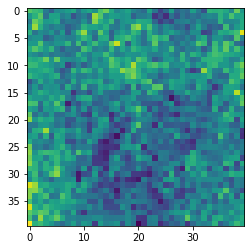

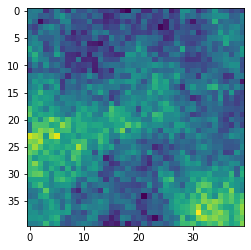

0.3
H=0.1 & r=0.3 finished in 2 its


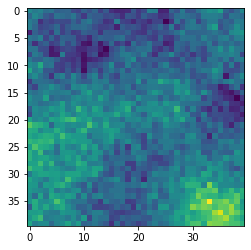

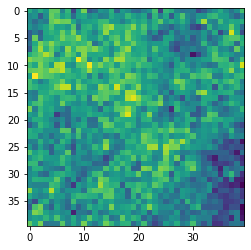

0.8
H=0.1 & r=0.6 finished in 4 its


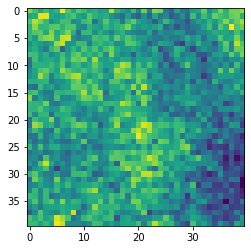

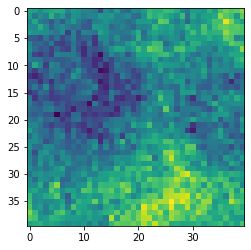

Seed 2 complete
0.7
0.8
0.9
H=0.5 & r=0.3 finished in 122 its


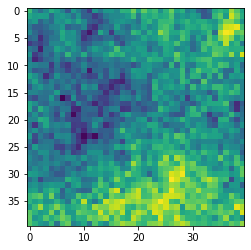

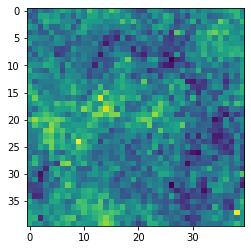

0.7
0.8
0.9
H=0.5 & r=0.6 finished in 71 its


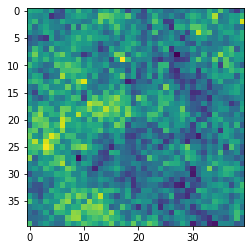

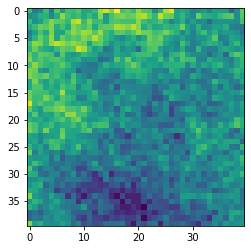

0.2
0.6
H=0.1 & r=0.3 finished in 5 its


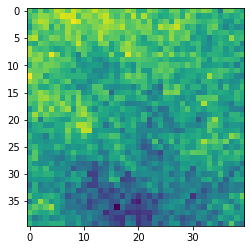

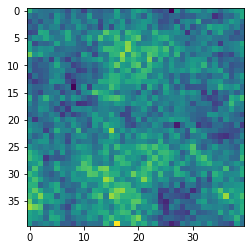

0.5
0.6
H=0.1 & r=0.6 finished in 12 its


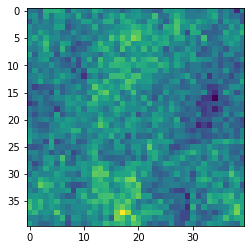

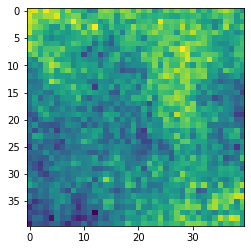

Seed 3 complete


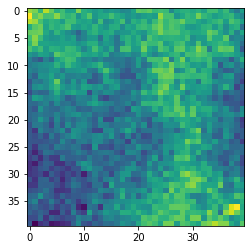

In [86]:
size = 40

variogram_model='spherical'
grf_alpha=1
n_lyrs = 2

rvec = [0.3, 0.6]
nkrigvec = [100, 100]

for seed in [1, 2, 3]:
    np.random.seed(seed)
    for H in [0.5, 0.1]:
        for rfix in [0, 1]:
            r = 0
            rmax=0.1
            count = 1
            while(r != rvec[rfix]):
                env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha, h=H, n_krig_pts=nkrigvec[rfix], variogram_model='spherical')
                env1 = mnlm[0]
                env2 = mnlm[1]
                env1sub = [item for sublist in env1 for item in sublist]
                env2sub = [item for sublist in env2 for item in sublist]
                r = np.corrcoef(env1sub,env2sub)[1][0].round(1)
                count = count + 1
                if(rmax < r):
                    rmax = r
                    print(rmax)
            print("H="+str(H)+" & r="+str(rvec[rfix])+" finished in "+str(count)+" its")
            plt.show()
            plt.imshow(env1)
            plt.show()
            plt.imshow(env2)
            np.savetxt("data/"+"seed"+str(seed)+"_env1_H0"+str(int(H*10))+"_r0"+str(int(r*10))+"_DTH.csv", env1, delimiter=",")
            np.savetxt("data/"+"seed"+str(seed)+"_env2_H0"+str(int(H*10))+"_r0"+str(int(r*10))+"_DTH.csv", env2, delimiter=",")
    print("Seed "+str(seed)+" complete")
            

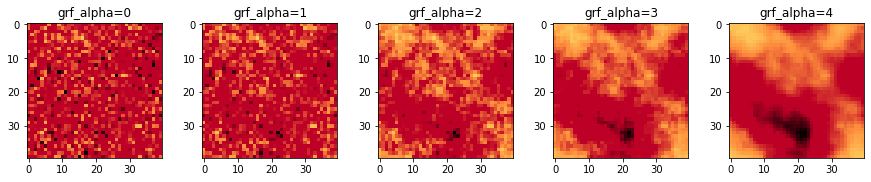

In [57]:
size = 40

variogram_model='spherical'
n_lyrs = 2 

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.3)

axs = axs.ravel()

grf_alpha = range(5)
for i in range(len(grf_alpha)):
    np.random.seed(42)
    env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha[i], h=0.5, n_krig_pts=10, variogram_model='spherical')
    axs[i].imshow(mnlm[1], aspect=1, cmap=cmapCont)
    axs[i].set_title("grf_alpha="+str(grf_alpha[i]))


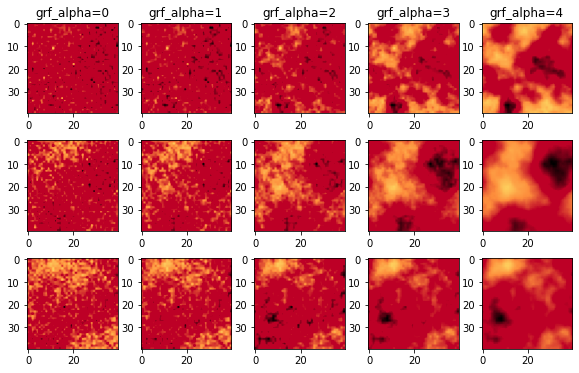

In [67]:
size = 40

variogram_model='spherical'
n_lyrs = 1 

fig, axs = plt.subplots(3,5, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.1)

axs = axs.ravel()

grf_alpha = range(5)
for i in range(len(grf_alpha)):
    np.random.seed(42)
    env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha[i], h=0.1, n_krig_pts=10, variogram_model='spherical')
    axs[i].imshow(mnlm[0], aspect=1, cmap=cmapCont)
    axs[i].set_title("grf_alpha="+str(grf_alpha[i]))

grf_alpha = range(5)
for i in range(len(grf_alpha)):
    np.random.seed(42)
    env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha[i], h=0.1, n_krig_pts=100, variogram_model='spherical')
    axs[i+5].imshow(mnlm[0], aspect=1, cmap=cmapCont)
    
grf_alpha = range(5)
for i in range(len(grf_alpha)):
    np.random.seed(42)
    env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha[i], h=0.1, n_krig_pts=1000, variogram_model='spherical')
    axs[i+10].imshow(mnlm[0], aspect=1, cmap=cmapCont)

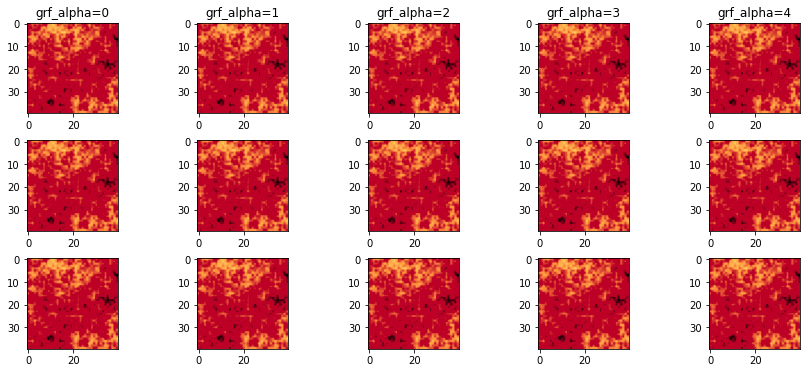

In [64]:
size = 40

variogram_model='spherical'
n_lyrs = 1

fig, axs = plt.subplots(3,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.1)

axs = axs.ravel()

grf_alpha = range(5)
for i in range(len(grf_alpha)):
    np.random.seed(42)
    env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha[i], h=0.1, n_krig_pts=10, variogram_model='spherical')
    axs[i].imshow(env, aspect=1, cmap=cmapCont)
    axs[i].set_title("grf_alpha="+str(grf_alpha[i]))

grf_alpha = range(5)
for i in range(len(grf_alpha)):
    np.random.seed(42)
    env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha[i], h=0.1, n_krig_pts=100, variogram_model='spherical')
    axs[i+5].imshow(env, aspect=1, cmap=cmapCont)
    
grf_alpha = range(5)
for i in range(len(grf_alpha)):
    np.random.seed(42)
    env, mnlm = draw_mv_mpd(n_lyrs, size, grf_alpha[i], h=0.1, n_krig_pts=1000, variogram_model='spherical')
    axs[i+10].imshow(env, aspect=1, cmap=cmapCont)

Text(0.5, 1.0, 'Base NLM')

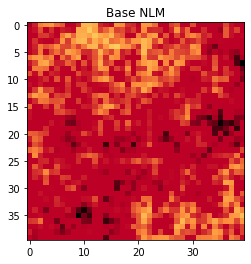

In [79]:
fig, axs = plt.subplots(1,1, figsize=(4, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.1)

plt.imshow(env, aspect=1, cmap=cmapCont)
axs.set_title("Base NLM")